In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import cv2
import numpy as np
import random
import os

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten

In [4]:
gpus= tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [5]:
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')

In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
#decompress the file
!tar -xf lfw.tgz

In [ ]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [6]:
import uuid

In [7]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\a6755b9a-245d-11ed-8ab9-b40ede7bf736.jpg'

In [8]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

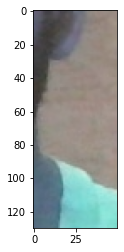

In [9]:
plt.imshow(frame[120:120+250,200:200+250, :])

In [10]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(120)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(120)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(120)

In [11]:
dir_test = anchor.as_numpy_iterator()

In [12]:
print(dir_test.next())

b'data\\anchor\\a597fa00-22f3-11ed-a140-b40ede7bf736.jpg'


In [13]:
def preprocess(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100,100))
    img = img / 255.0
    return img

In [14]:
img = preprocess('data\\negative\\Abdullah_Ahmad_Badawi_0001.jpg')

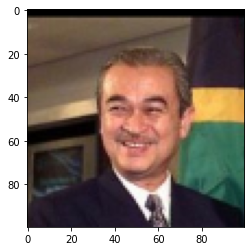

In [15]:
plt.imshow(img)

In [16]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [17]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [18]:
samples = data.as_numpy_iterator()
example = samples.next()
example

(b'data\\anchor\\665d9dcc-22f5-11ed-a70f-b40ede7bf736.jpg',
 b'data\\positive\\09686606-22f6-11ed-a197-b40ede7bf736.jpg',
 1.0)

In [19]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [20]:
res = preprocess_twin(*example)

In [21]:
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.4759804 , 0.44852942, 0.41715688],
         [0.47083333, 0.44338235, 0.41004902],
         [0.46544117, 0.4379902 , 0.3987745 ],
         ...,
         [0.60857844, 0.6164216 , 0.59681374],
         [0.6193628 , 0.6272059 , 0.60759807],
         [0.6245098 , 0.63235295, 0.62058824]],
 
        [[0.4595588 , 0.43210784, 0.3987745 ],
         [0.45784312, 0.43039215, 0.39117646],
         [0.45367646, 0.43504903, 0.39289215],
         ...,
         [0.6007353 , 0.60857844, 0.59093136],
         [0.6188725 , 0.62671566, 0.60906863],
         [0.6137255 , 0.6215686 , 0.60784316]],
 
        [[0.46960783, 0.44215685, 0.40294117],
         [0.45367646, 0.42843136, 0.3884804 ],
         [0.45465687, 0.43823528, 0.39534312],
         ...,
         [0.6156863 , 0.62352943, 0.6117647 ],
         [0.6137255 , 0.6215686 , 0.6098039 ],
         [0.6159314 , 0.62083334, 0.6012255 ]],
 
        ...,
 
        [[0.3970588 , 0.28946078

In [22]:
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)

In [23]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [24]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [25]:
def make_embedding():
    inp = Input(shape=(100,100,3), name = "input_image")
    c1 = Conv2D(64,(10,10),activation = "relu")(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [26]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [27]:
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [28]:
l1 = L1Dist()

In [29]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

In [30]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
classifier = Dense(1, activation='sigmoid')(distances)
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [31]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [32]:
siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

In [33]:
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [34]:
@tf.function
def train_step(batch):
    
    with tf.GradientTape() as tape:     
       
        X = batch[:2]
       
        y = batch[2]
        
        yhat = siamese_model(X, training=True)
       
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
   
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    return loss

In [35]:
from tensorflow.keras.metrics import Precision, Recall


def train(data, EPOCHS):
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
         
        r = Recall()
        p = Precision()
        
        for idx, batch in enumerate(data):
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [36]:
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
11/11 [==============================] - 11s 638ms/step
0.2992157 0.11392405 1.0

 Epoch 2/50
11/11 [==============================] - 6s 497ms/step
0.25286984 0.3956044 1.0

 Epoch 3/50
11/11 [==============================] - 5s 472ms/step
0.22880998 0.8902439 1.0

 Epoch 4/50
11/11 [==============================] - 5s 475ms/step
0.16203591 0.94186044 1.0

 Epoch 5/50
11/11 [==============================] - 5s 471ms/step
0.20172463 0.94382024 1.0

 Epoch 6/50
11/11 [==============================] - 5s 481ms/step
0.056218784 1.0 1.0

 Epoch 7/50
11/11 [==============================] - 6s 525ms/step
0.0397625 1.0 1.0

 Epoch 8/50
11/11 [==============================] - 6s 520ms/step
0.016670309 1.0 1.0

 Epoch 9/50
11/11 [==============================] - 6s 513ms/step
0.063356094 1.0 1.0

 Epoch 10/50
11/11 [=======

In [37]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [38]:
y_hat = siamese_model.predict([test_input, test_val])

In [39]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1]

In [40]:
y_true

array([1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1.],
      dtype=float32)

In [41]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [42]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [43]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1.0 1.0


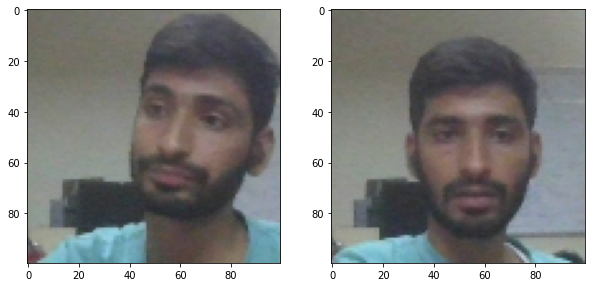

In [44]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

# Renders cleanly
plt.show()

In [45]:
siamese_model.save('siamesemodelv2.h5')
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})
siamese_model.predict([test_input, test_val])
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_3 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [46]:
os.listdir(os.path.join('application_data', 'verification_images'))
os.path.join('application_data', 'input_image', 'input_image.jpg')
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\0669468a-22f6-11ed-bb81-b40ede7bf736.jpg
application_data\verification_images\06a00136-22f6-11ed-8c8f-b40ede7bf736.jpg
application_data\verification_images\06bcad8a-22f6-11ed-9551-b40ede7bf736.jpg
application_data\verification_images\0a1ae822-22f6-11ed-9241-b40ede7bf736.jpg
application_data\verification_images\0f05eda8-22f6-11ed-92d7-b40ede7bf736.jpg
application_data\verification_images\4b406b80-22f4-11ed-94f3-b40ede7bf736.jpg
application_data\verification_images\4db4e4a6-22f4-11ed-841f-b40ede7bf736.jpg
application_data\verification_images\50a10b76-22f4-11ed-b203-b40ede7bf736.jpg
application_data\verification_images\5366faf4-22f4-11ed-ad6d-b40ede7bf736.jpg
application_data\verification_images\7b609fa4-22f5-11ed-bfe1-b40ede7bf736.jpg
application_data\verification_images\7d7b3d12-22f5-11ed-ba36-b40ede7bf736.jpg
application_data\verification_images\7e15fa5c-22f5-11ed-82d7-b40ede7bf736.jpg
application_data\verification_images\809a61cc-22f5-11ed-98e7-b40

In [47]:
def verify(model, detection_threshold, verification_threshold):
    
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    detection = np.sum(np.array(results) > detection_threshold)
    
    
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [48]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
#         hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
#         h, s, v = cv2.split(hsv)

#         lim = 255 - 10
#         v[v > lim] = 255
#         v[v <= lim] -= 10
        
#         final_hsv = cv2.merge((h, s, v))
#         img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

False
True
True


In [49]:
model.summary()

NameError: name 'model' is not defined